# 1. Import Libraries
Import the necessary libraries for data manipulation (`numpy`, `pandas`), visualization (`matplotlib`), and file handling (`os`).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

# 2. Loading Data from Kaggle Input Directory
list all files in the Kaggle input directory. It helps verify that the required datasets (`train.csv`, `test.csv`, and `sample_submission.csv`) are available.

In [2]:
# Walk through the Kaggle input directory and print file paths
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# 3. Load the Training Data

In [3]:
# Load the training data into a pandas DataFrame
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

# Display the first 5 rows of the dataset
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This cell loads the training data from `train.csv` and displays the first 5 rows. Each row represents a **28x28 grayscale image** of a handwritten digit (0-9), flattened into 784 pixel values, with an additional column for the label.

# 4. Preprocessing the Data

In [4]:
# Convert the DataFrame to a NumPy array for easier manipulation
data = np.array(data)

# Get the number of rows (m) and columns (n) in the dataset
m, n = data.shape

# Shuffle the data to ensure randomness
np.random.shuffle(data)

# Split the data into development (dev) and training sets
data_dev = data[0:1000].T  # Transpose for easier column access
Y_dev = data_dev[0]        # Labels for dev set
X_dev = data_dev[1:n]      # Pixel values for dev set
X_dev = X_dev / 255.       # Normalize pixel values to [0, 1]

data_train = data[1000:m].T  # Transpose for easier column access
Y_train = data_train[0]      # Labels for training set
X_train = data_train[1:n]    # Pixel values for training set
X_train = X_train / 255.     # Normalize pixel values to [0, 1]

# Get the number of training examples
_, m_train = X_train.shape

**We preprocess the data by:**
1. Converting the DataFrame to a NumPy array.
2. Shuffling the data to ensure randomness.
3. Splitting the data into a development set (1000 examples) and a training set.
4. Normalizing pixel values to the range [0, 1] for better model performance.

# 5. Neural Network Functions

## 5.1 Initialize Parameters
This function initializes the weights and biases for the neural network. The weights are randomly initialized to small values, and biases are initialized similarly.

In [5]:
def init_params():
    # Initialize weights and biases randomly
    W1 = np.random.rand(10, 784) - 0.5  # Weights for the first layer
    b1 = np.random.rand(10, 1) - 0.5    # Biases for the first layer
    W2 = np.random.rand(10, 10) - 0.5   # Weights for the second layer
    b2 = np.random.rand(10, 1) - 0.5    # Biases for the second layer
    return W1, b1, W2, b2

## 5.2 Activation Functions
* **`ReLU`**: Applies the Rectified Linear Unit activation function, which outputs the input directly if it is positive; otherwise, it outputs zero.
*  **`ReLU_deriv`**: The derivative of the ReLU function is defined as:
    * 1 if the input is greater than 0.
    * 0 otherwise.
* **`softmax`**: Converts the output into a probability distribution.

In [6]:
def ReLU(Z):
    # ReLU activation function
    return np.maximum(Z, 0)

def ReLU_deriv(Z):
    # Derivative of the ReLU function
    return Z > 0

def softmax(Z):
    # Softmax activation function for the output layer
    A = np.exp(Z) / sum(np.exp(Z))
    return A

## 5.3 One-Hot Encoding Function
This function converts the labels (e.g., `[0, 1, 2, ..., 9]`) into one-hot encoded vectors. For example:
* If Y = [2, 5], the output will be:
[[0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

In [7]:
def one_hot(Y):
    # Convert labels to one-hot encoded vectors
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))  # Create a matrix of zeros
    one_hot_Y[np.arange(Y.size), Y] = 1          # Set the appropriate indices to 1
    one_hot_Y = one_hot_Y.T                      # Transpose to match the required shape
    return one_hot_Y

## 5.4 Forward Propagation
This function computes the forward pass through the neural network, applying linear transformations and activation functions.

In [8]:
def forward_prop(W1, b1, W2, b2, X):
    # Forward propagation through the network
    Z1 = W1.dot(X) + b1  # Linear transformation for the first layer
    A1 = ReLU(Z1)        # Apply ReLU activation
    Z2 = W2.dot(A1) + b2 # Linear transformation for the second layer
    A2 = softmax(Z2)     # Apply softmax activation
    return Z1, A1, Z2, A2

## 5.5 Backward Propagation
This function computes the gradients of the loss with respect to the weights and biases using backpropagation.

In [9]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    # Backward propagation to compute gradients
    one_hot_Y = one_hot(Y)  # Convert labels to one-hot encoding
    dZ2 = A2 - one_hot_Y    # Error at the output layer
    dW2 = 1 / m * dZ2.dot(A1.T)  # Gradient for W2
    db2 = 1 / m * np.sum(dZ2)    # Gradient for b2
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)  # Error at the hidden layer
    dW1 = 1 / m * dZ1.dot(X.T)   # Gradient for W1
    db1 = 1 / m * np.sum(dZ1)    # Gradient for b1
    return dW1, db1, dW2, db2

## 5.6 Update Parameters
This function updates the weights and biases using the computed gradients and a learning rate (`alpha`).

In [10]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    # Update weights and biases using gradient descent
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

## 5.7 Gradient Descent
This function trains the neural network using gradient descent. It prints the accuracy every 10 iterations.

In [11]:
# Get predictions
def get_predictions(A2):
    return np.argmax(A2, 0)

# Get accuracy
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    # Train the model using gradient descent
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

# 6. Training the Model
We train the model and prints the accuracy at regular intervals.

In [12]:
# Train the model with a learning rate of 0.10 for 500 iterations
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
0.09368292682926829
Iteration:  10
0.18080487804878048
Iteration:  20
0.27682926829268295
Iteration:  30
0.3689512195121951
Iteration:  40
0.43485365853658536
Iteration:  50
0.49017073170731706
Iteration:  60
0.538
Iteration:  70
0.5789756097560975
Iteration:  80
0.6157073170731707
Iteration:  90
0.6423170731707317
Iteration:  100
0.6643902439024391
Iteration:  110
0.6828780487804879
Iteration:  120
0.6993658536585365
Iteration:  130
0.7128536585365853
Iteration:  140
0.7244634146341463
Iteration:  150
0.7354878048780488
Iteration:  160
0.7446341463414634
Iteration:  170
0.7525609756097561
Iteration:  180
0.7608780487804878
Iteration:  190
0.7688048780487805
Iteration:  200
0.7747317073170732
Iteration:  210
0.7810243902439025
Iteration:  220
0.7860731707317073
Iteration:  230
0.7902926829268293
Iteration:  240
0.7947560975609756
Iteration:  250
0.7991219512195122
Iteration:  260
0.8037073170731708
Iteration:  270
0.8069268292682927
Iteration:  280
0.8103414634146342
Iter

# 7. Making Predictions
Test the model on specific examples and displays the predicted and actual labels along with the image.

Prediction:  [6]
Label:  6


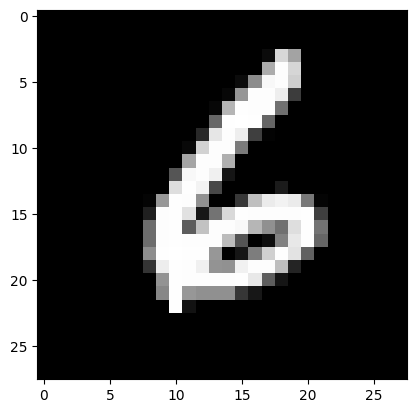

Prediction:  [1]
Label:  1


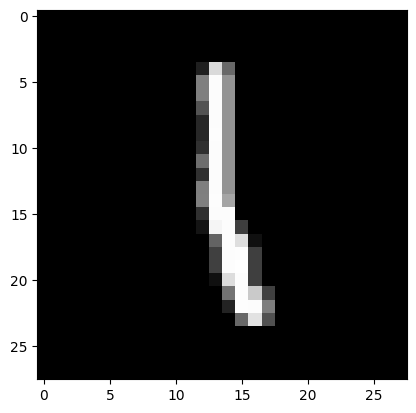

Prediction:  [4]
Label:  4


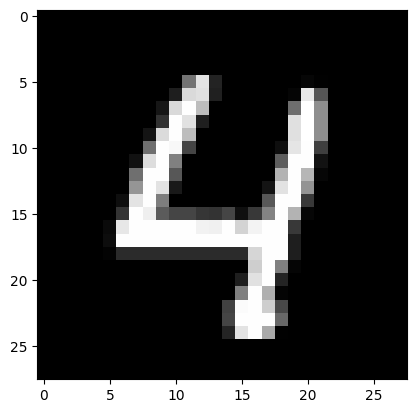

Prediction:  [7]
Label:  9


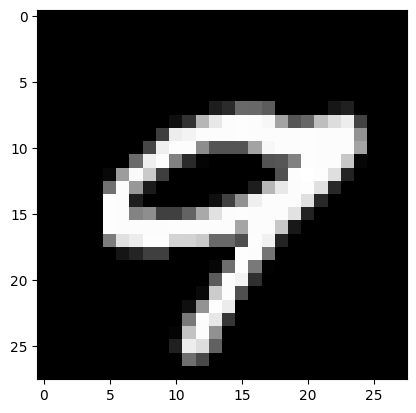

In [13]:
def make_predictions(X, W1, b1, W2, b2):
    # Make predictions using the trained model
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    # Test the model on a specific example
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    # Display the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

# Test the model on a few examples
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

# 8. Kaggle Submission
Generate predictions for the test data and creates a submission file for the Kaggle competition.

In [14]:
# Load the test data
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_data = np.array(test_data)
test_data = test_data.T
test_data = test_data / 255.

# Make predictions on the test data
predictions = make_predictions(test_data, W1, b1, W2, b2)

# Create a submission file
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)